<p style="font-family: Georgia;font-size: 120%"> General information about notebook </p>
<ul  style="font-family: Georgia;font-size: 120%">
    <li> Area:
        <ul><li>Medicine, Neuroscience</li></ul>
    </li>
    <li> Topic covered:
        <ul><li>Brain Tumor Detection</li></ul>
    </li>
    <li> Tools applied:
        <ul><li>TensorFlow</li>
            <li>Convolutional Neural Networks (CNN)</li>
            <li>Transfer Learning</li>
        </ul>
    </li>
    <li> Author:
        <ul><li>Farid Taghiyev</li></ul>
    </li>
    <li> Region:
        <ul><li>Baku, Azerbaijan</li></ul>
    </li>
    <li> Date:
        <ul><li>Feb , 2022</li></ul>
    </li>
</ul>

<h2 style="font-family: Georgia;font-size: 150%"> Contents </h2> 


* [Introduction](#intro)
* [Data](#data)
    - [Reading](#data-reading)
    - [Processing](#data-processing)
* [Models](#models)
    - [Simple CNN-based Model](#models-cnn)
        - [Creating](#models-cnn-creating)
        - [Training](#models-cnn-training)
        - [Results](#models-cnn-results)
    - [Transfer Learning](#models-transfer_learning)
        - [MobileNetV2](#models-transfer_learning-mobilenetv2)
            - [Structure](#models-transfer_learning-mobilenetv2-structure)
            - [Training](#models-transfer_learning-mobilenetv2-training)
            - [Results](#models-transfer_learning-mobilenetv2-results)
        - [InceptionResnetV2](#models-transfer_learning-inceptionResnetv2)
            - [Structure](#models-transfer_learning-inceptionResnetv2-structure)
            - [Training](#models-transfer_learning-inceptionResnetv2-training)
            - [Results](#models-transfer_learning-inceptionResnetv2-results)
        - [VGG16](#models-transfer_learning-vgg16)
            - [Structure](#models-transfer_learning-vgg16-structure)
            - [Training](#models-transfer_learning-vgg16-training)
            - [Results](#models-transfer_learning-vgg16-results)
* [Conclusion](#conclusion)
    - [Overall Results](#conclusion-overall_results)

<a id = "intro"></a>
# Introduction

<p style="font-family: Georgia;font-size: 120%">
  To start with, it would be better to first define tumor itself. In humans body usually when cell gets older or is being damaged it dies and new cell comes into its place. In some cases, this proccess doesn't occur and instead <font color="red">abnormal</font> or <font color="red">damaged</font> cells start to grow in much faster fashion (even though they shouldn't). Consequently, these cells might trigger tumor which is basically lump of tissue. In Neuroscience, <b>brain tumor</b> is just one of the several types of tumors.Some brain tumors are <font color= "green"> noncancerous </font> (benign) and some of them are <font color="red">concerous</font> (malignant). Since dataset itself doesn't contain much of description, we will assume that it contains both benign and malignant tumors.
    
</p>

In [1]:
 !pip install tensorflow pathlib shutil seaborn sklearn pandas

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import shutil
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight 
import pandas as pd

ModuleNotFoundError: No module named 'tensorflow'

In [290]:
def plot_categories(training_images, training_labels,mapping = None, count = 10):
  fig, axes = plt.subplots(int(np.sqrt(count))+1, int(np.sqrt(count))+1, figsize=(16, 15))
  axes = axes.flatten()
    
  for ax in axes:
    ax.set_axis_off()

  for k in range(count):
    img = training_images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.set_axis_on()
    ax.imshow(img, cmap="Greys_r")
    label = None
    if mapping:
        label = mapping[training_labels[k]]
    else:
        label = training_labels[k]
        
    ax.set_title(label)
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [291]:
# Functions of this cell and additional information were originally taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data.

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    
    
    
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-tumor detected (True Negatives): ', cm[0][0])
  print('Non-tumor incorrectly detected (False Positives): ', cm[0][1])
  print('Tumor missed (False Negatives): ', cm[1][0])
  print('Tumor detected (True Positives): ', cm[1][1])
  print('Total case: ', np.sum(cm[1]))

<a id = "data"></a>
# Data

<a id = "data-reading"></a>
## Reading

<i style="font-family: Georgia;font-size: 120%">Structure of the folder is the following:</i>
<p style="font-family: Courier;font-size: 120%">
(root) brain-mri-images-for-brain-tumor-detection <br>
    &emsp;|<br>
    &emsp;|____ no<br>
    &emsp;|<br>
    &emsp;|____ yes<br>
    &emsp;|<br>
    &emsp;|____ brain_tumor_dataset (hidden folder)<br>
    &emsp;&emsp;&emsp;&emsp;|<br>
    &emsp;&emsp;&emsp;&emsp;|____ no<br>
    &emsp;&emsp;&emsp;&emsp;|<br>
    &emsp;&emsp;&emsp;&emsp;|____ yes <br>
</p>

<p style="font-family: Georgia;font-size: 120%">Extracting data from <i> root </i> folder will cause issues since hidden folder creates confusion. It occurs because from information about directories it recognizes three classes instead of two. So, it would be better to proceed with hidden folder. </p>

In [292]:
data_path = pathlib.Path("../input/brain-mri-images-for-brain-tumor-detection/")
data_path = os.path.join(data_path, os.listdir(data_path)[2])

<p style="font-family: Georgia;font-size: 120%">
    To avoid possible <font color="red">overfitting</font> and improve <font color="green">generalization</font> we will use image augmentation
    via ImageDataGenerator
    
</p>

In [293]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


<p style="font-family: Georgia;font-size: 120%"> How augmented images look like: </p>

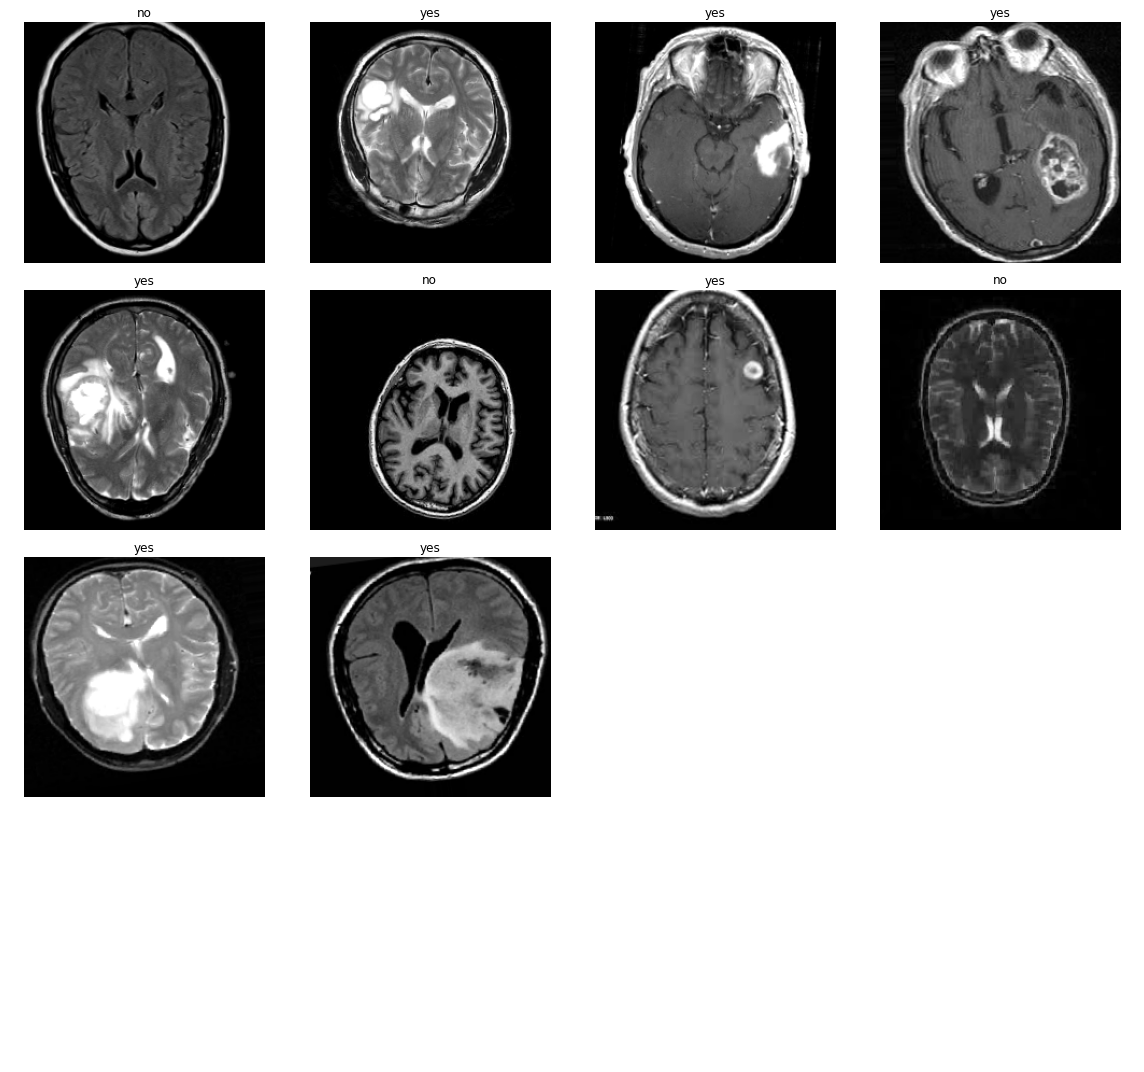

In [294]:
sample_X , sample_y = train_generator.next()
mapping = {1:"yes" , 0:"no"}

plot_categories(sample_X,sample_y,mapping,sample_X.shape[0])

<p style="font-family: Georgia;font-size: 120%"> So, if we look closely, we would see that image where there is tumor contains either black or white spot/s and sometimes they are surrounded by white contour. Our purpose would be then to teach model recognize those patterns.  </p>

<p style="font-family: Georgia;font-size: 120%"> Distribution of classes in given dataset: </p>

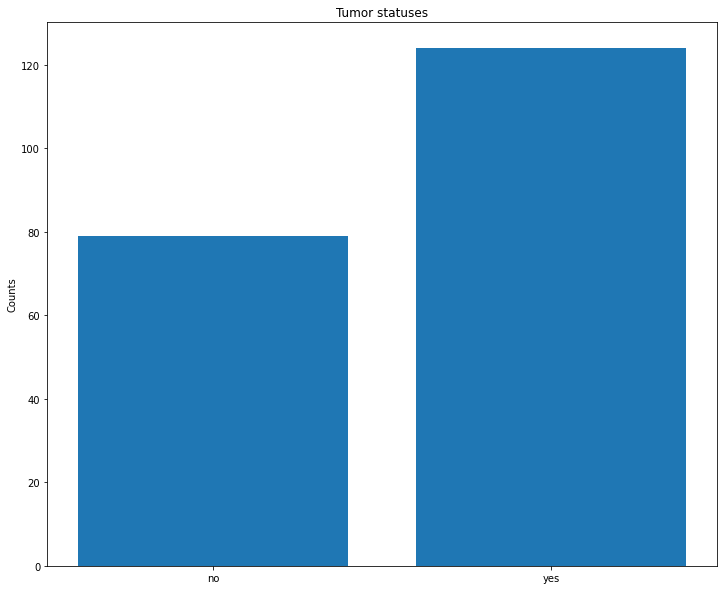

In [295]:
labels, counts = np.unique(train_generator.labels, return_counts = True)
labels = [mapping[l] for l in labels]

fig, ax = plt.subplots()
ax.set_ylabel('Counts')
ax.set_title('Tumor statuses')
ax.bar(labels, counts)

plt.show()

<p style="font-family: Georgia;font-size: 120%"> As we can see classes are imbalanced (not heavily, but still imbalanced). In <b>processing</b> section we will try to overcome this problem. </p>

<a id="data-processing"></a>

## Processing

<p style="font-family: Georgia;font-size: 120%"> For each class we assign different <i>weights</i> (higher wieghts for lower class and lower weights for higher class), so that during training process imbalanced data is considered while <i>loss</i> is calculated</p>

In [296]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes), train_generator.classes)
train_class_weights = dict(enumerate(class_weights))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<p style="font-family: Georgia;font-size: 120%"> Alright, weights are created and we will use them during training. Now let's dive into model creation and training !</p>

<a id = "models"></a>
# Models

<p style="font-family: Georgia;font-size: 120%"> As above mentioned, we will apply both model created from scratch using CNN and more complex models trained on large datasets (<i>transfer learning</i>).</p>

In [297]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

<p style="font-family: Georgia;font-size: 120%"> Before moving on , let's define metrics written above and see what they mean.</p>

<p style="font-family: Georgia;font-size: 120%"> 
    suppose: <br>
    &emsp;<i>yes</i> - positive class <br>
    &emsp;<i>no</i> - negative class
    
</p> 
<p>
<ul style="font-family: Georgia;font-size: 120%">
    <li> True Positive (TP) - case when our model predicted <font color="green">positive</font> for <font color="green">positive</font> class </li>
    <li> True Negative (TN) - case when our model predicted <font color="red">negative</font> for <font color="red">negative</font> class</li>
    <li> False Positive (FP) - case when our model predicted <font color="green">positive</font> for <font color="red">negative</font> class </li>
    <li> False Negative (FN) - case when our model predicted <font color="red">negative</font> for <font color="green">positive</font> class </li>
    <li> Binary Accuracy = (TP + TN)/(TP+TN+FP+FN). It simply describes when our model predicted correctly and in perfect case binary accuracy is 1. </li>
    <li> Precision = TP / (TP + FP) = TP / Total_Predicted_Positive . As we can see from formula, it describes that for all cases when model predicted class to be <font color="green">positive</font> how many of them are actually <font color="green">positive</font>. In ideal case, if FP = 0 then Precision = 0.</li>
    <li> Recall = TP / (TP + FN) = TP / Total_Actual_Positive. From formula we can see that recall actually describes for all inputs value of which are <font color="green">positive</font>, how much of them were correctly labeled as <font color="green">positive</font>.</li>
    <li> True Positive Rate (TPR) - synonym for <i> Recall </i> </li>
    <li> False Positive Rate (FPR) = FP / (FP + TN) = FP / Total_Actual_Negative. This rate defines for all inputs value of which are <font color="red">negative</font> how much of them were labeled as <font color="green">positive</font>. Both <i>TPR</i> and <i>FPR</i> will be used to describe <i> ROC</i> curve.</li>
    <li> ROC curve - a curve showing perfomance of classification model at various classification threshold. Curve is defined as a mapping from set of all <i>TPR</i>s to set of all <i>FPR</i>s (TPR vs. FPR).</li>
    <li> AUC - simply area under the ROC curve. So when AUC is high, there are high chances that predictions will be TP and TN. For example, when AUC = 0. 8, it means there are 80% of chance that model will successfully distinguish <font color="green">positive</font> class from <font color="red">negative</font>. AUC = 0.5 means that model has no capacity to distinguish these two classes.</li>
</ul>


<p style="font-family: Georgia;font-size: 120%">
For more information, please refer to: <br>
1) https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative <br>
2) https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 <br>
3) https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 <br>
</p>

<a id = "models-cnn"></a>

## Simple CNN-based Model

<a id = "models-cnn-creating"></a>
### Creating

In [298]:
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      tf.keras.layers.MaxPooling2D(pool_size = (3,3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(units = 512 , activation="relu"),
      tf.keras.layers.Dropout(rate = 0.5),
      tf.keras.layers.Dense(units = 1 , activation="sigmoid")
  ])

In [299]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0008),
                loss = "binary_crossentropy",
                metrics=metrics)

tf.keras.utils.plot_model(model) # image of models structure you can get from output folder
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4681 (Conv2D)         (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_4682 (Conv2D)         (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4683 (Conv2D)         (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1568)            

<a id = "models-cnn-training"></a>
### Training

In [300]:
history1 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/20
21/21 [==============================] - 6s 228ms/step - loss: 0.7020 - tp: 68.0000 - fp: 36.0000 - tn: 43.0000 - fn: 56.0000 - accuracy: 0.5468 - precision: 0.6538 - recall: 0.5484 - auc: 0.5508 - prc: 0.6631 - val_loss: 0.6213 - val_tp: 22.0000 - val_fp: 9.0000 - val_tn: 10.0000 - val_fn: 9.0000 - val_accuracy: 0.6400 - val_precision: 0.7097 - val_recall: 0.7097 - val_auc: 0.7742 - val_prc: 0.8719
Epoch 2/20
21/21 [==============================] - 4s 186ms/step - loss: 0.5965 - tp: 88.0000 - fp: 19.0000 - tn: 60.0000 - fn: 36.0000 - accuracy: 0.7291 - precision: 0.8224 - recall: 0.7097 - auc: 0.7714 - prc: 0.7866 - val_loss: 0.5229 - val_tp: 29.0000 - val_fp: 10.0000 - val_tn: 9.0000 - val_fn: 2.0000 - val_accuracy: 0.7600 - val_precision: 0.7436 - val_recall: 0.9355 - val_auc: 0.8192 - val_prc: 0.8834
Epoch 3/20
21/21 [==============================] - 4s 172ms/step - loss: 0.5825 - tp: 94.0000 - fp: 23.0000 - tn: 56.0000 - fn: 30.0000 - accuracy: 0.7389 - precision: 0.8

In [301]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.47412723302841187
tp :  28.0
fp :  7.0
tn :  12.0
fn :  3.0
accuracy :  0.800000011920929
precision :  0.800000011920929
recall :  0.9032257795333862
auc :  0.8421052098274231
prc :  0.8745148181915283


Non-tumor detected (True Negatives):  12
Non-tumor incorrectly detected (False Positives):  7
Tumor missed (False Negatives):  3
Tumor detected (True Positives):  28
Total case:  31


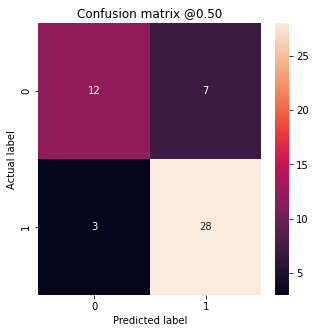

In [302]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.labels

plot_cm(labels, validation_predictions)

<a id = "models-cnn-results"></a>
### Results

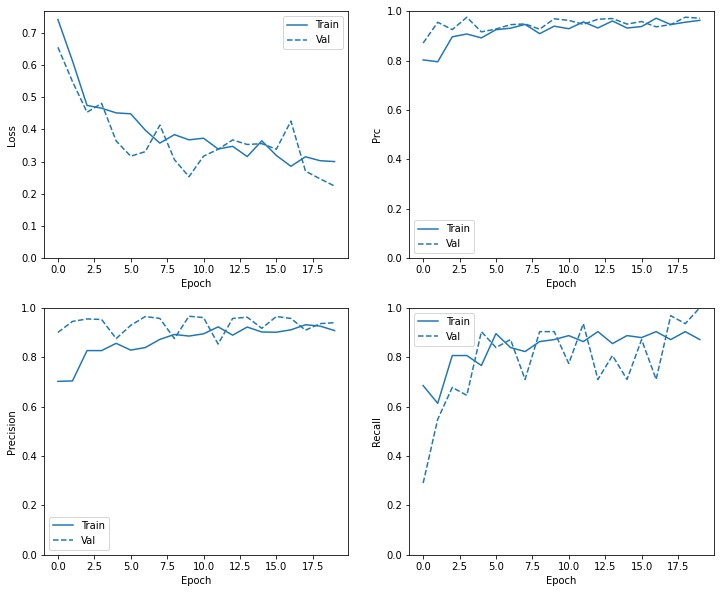

In [303]:
plot_metrics(history)

<p style="font-family: Georgia;font-size: 120%"> If one applies training for both augmented and non-augmented images, he/she will notice that image augmentation along with droput dramatically reduces overfitting making training and validation converge. Results show that we achieved model which classifies not so bad (AUC > 80%). Let's see if we can improve these results via <i> transfer learning </i></p>

<a id="models-transfer_learning"></a>

## Transfer Learning

<p style="font-family: Georgia;font-size: 120%"> To start with, let's first of all define what transfer learning means. Above you have already seen that our simple model is generally good, but not that much to be used in real life. The reason might be either its simplicity, lack of data, or both of them. So, what if we would take a bit more complicated model created by team of researches and give to it weights that were obtained from training on 14 million images (<i>ImageNet</i>). Basically, transfer learning is what we just mentioned - we apply model learned from another task to our own task which is somehow similar to original one. </p>

<p style="font-family: Georgia;font-size: 120%"> Let's go through more lightweight models to a bit complicated ones</p>

<a id = "models-transfer_learning-mobilenetv2"></a>

### MobileNetV2

<a id = "models-transfer_learning-mobilenetv2-structure"></a>
#### Model Structure

For more information about structure and working principle of MobileNetV2 please refer to
[MobileNetV2 — Light Weight Model (Image Classification)](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c)

![MobileNetV2 architecture](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)

<a id = "models-transfer_learning-mobilenetv2-training"></a>
#### Training

<p style="font-family: Georgia;font-size: 120%"> Here we redefine train and validation generator since base model expects pixel values in range [-1,1] however previously we had [0,1]. We will use these generators for other transfer learning models. </p>

In [304]:
train_datagen = ImageDataGenerator(featurewise_center=True, 
                                     samplewise_center=True,
                                     rescale = 2/255.,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=data_path,
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    class_mode = "binary",
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory=data_path,
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            class_mode = "binary",
                                                            subset = "validation")

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [305]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalAveragePooling2D(),
                              tf.keras.layers.Dense(1024, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00008),
                loss = "binary_crossentropy",
                metrics=metrics)

# model.summary()

In [306]:
history2 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
21/21 [==============================] - 52s 271ms/step - loss: 0.6461 - tp: 98.0000 - fp: 34.0000 - tn: 64.0000 - fn: 57.0000 - accuracy: 0.6403 - precision: 0.7424 - recall: 0.6323 - auc: 0.7123 - prc: 0.7901 - val_loss: 0.4346 - val_tp: 28.0000 - val_fp: 4.0000 - val_tn: 15.0000 - val_fn: 3.0000 - val_accuracy: 0.8600 - val_precision: 0.8750 - val_recall: 0.9032 - val_auc: 0.9253 - val_prc: 0.9656
Epoch 2/20
21/21 [==============================] - 4s 184ms/step - loss: 0.4702 - tp: 95.0000 - fp: 17.0000 - tn: 62.0000 - fn: 29.0000 - accuracy: 0.7734 - precision: 0.8482 - recall: 0.7661 - auc: 0.8700 - prc: 0.9141 - val_loss: 0.3637 - val_tp: 27.0000 - val_fp: 1.0000 - val_tn: 18.0000 - val_fn: 4.0000 - val_accuracy: 0.9000 - val_precision: 0.9643 - val_recall: 0.8710 - val_auc: 0.9525 - val_prc: 0.9761
Epoch 3/20
21/21 [==============================] - 4s 195ms/step - loss: 0.3612 - tp: 111.0000 - fp: 13.0000 - tn: 66.0000 - fn: 13.0000 - accuracy: 0.8719 - precision: 0

In [307]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.20168350636959076
tp :  27.0
fp :  0.0
tn :  19.0
fn :  4.0
accuracy :  0.9200000166893005
precision :  1.0
recall :  0.8709677457809448
auc :  0.9779287576675415
prc :  0.988797664642334


Non-tumor detected (True Negatives):  19
Non-tumor incorrectly detected (False Positives):  0
Tumor missed (False Negatives):  4
Tumor detected (True Positives):  27
Total case:  31


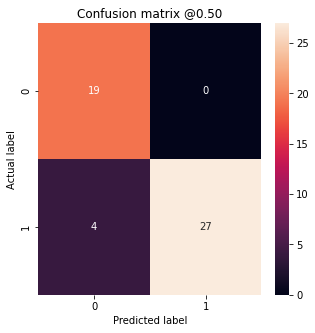

In [308]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

<a id = "models-transfer_learning-mobilenetv2-results"></a>
#### Results

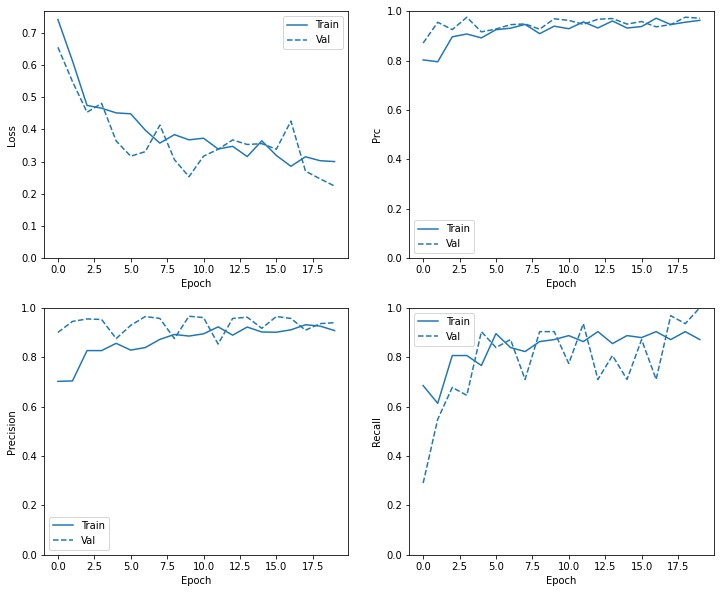

In [309]:
plot_metrics(history)

<p style="font-family: Georgia;font-size: 120%"> Much better, isn't it? As we can see, in comparison to simple model, number of FP and FN predictions decreased and precision for both training and validation tends to one. </p>

<a id="models-transfer_learning-inceptionResnetv2"></a>

### InceptionResnetV2

<a id = "models-transfer_learning-inceptionResnetv2-structure"></a>
#### Model Structure

![InceptionResnetV2 Architecture](https://www.researchgate.net/publication/325015329/figure/fig1/AS:624030189113350@1525791799624/Inception-Resnet-V2-Architecture.png)

<a id = "models-transfer_learning-inceptionResnetv2-training"></a>
#### Training

In [310]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation = 'relu'),
                              tf.keras.layers.Dropout(rate = 0.2),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

# model.summary()

In [311]:
history3 = model.fit(train_generator,epochs = 10, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/10
21/21 [==============================] - 19s 439ms/step - loss: 0.8698 - tp: 113.0000 - fp: 24.0000 - tn: 74.0000 - fn: 42.0000 - accuracy: 0.7391 - precision: 0.8248 - recall: 0.7290 - auc: 0.8036 - prc: 0.8229 - val_loss: 0.4565 - val_tp: 29.0000 - val_fp: 7.0000 - val_tn: 12.0000 - val_fn: 2.0000 - val_accuracy: 0.8200 - val_precision: 0.8056 - val_recall: 0.9355 - val_auc: 0.9117 - val_prc: 0.9507
Epoch 2/10
21/21 [==============================] - 5s 232ms/step - loss: 0.4649 - tp: 104.0000 - fp: 16.0000 - tn: 63.0000 - fn: 20.0000 - accuracy: 0.8227 - precision: 0.8667 - recall: 0.8387 - auc: 0.8897 - prc: 0.9193 - val_loss: 0.2651 - val_tp: 27.0000 - val_fp: 1.0000 - val_tn: 18.0000 - val_fn: 4.0000 - val_accuracy: 0.9000 - val_precision: 0.9643 - val_recall: 0.8710 - val_auc: 0.9643 - val_prc: 0.9797
Epoch 3/10
21/21 [==============================] - 4s 207ms/step - loss: 0.2659 - tp: 111.0000 - fp: 8.0000 - tn: 71.0000 - fn: 13.0000 - accuracy: 0.8966 - precision: 

In [312]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.24154070019721985
tp :  29.0
fp :  3.0
tn :  16.0
fn :  2.0
accuracy :  0.8999999761581421
precision :  0.90625
recall :  0.9354838728904724
auc :  0.9609507918357849
prc :  0.9748449921607971


Non-tumor detected (True Negatives):  16
Non-tumor incorrectly detected (False Positives):  3
Tumor missed (False Negatives):  2
Tumor detected (True Positives):  29
Total case:  31


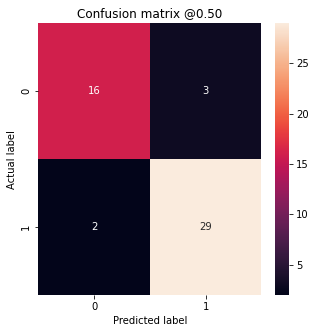

In [313]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

<a id = "models-transfer_learning-inceptionResnetv2-results"></a>
#### Results

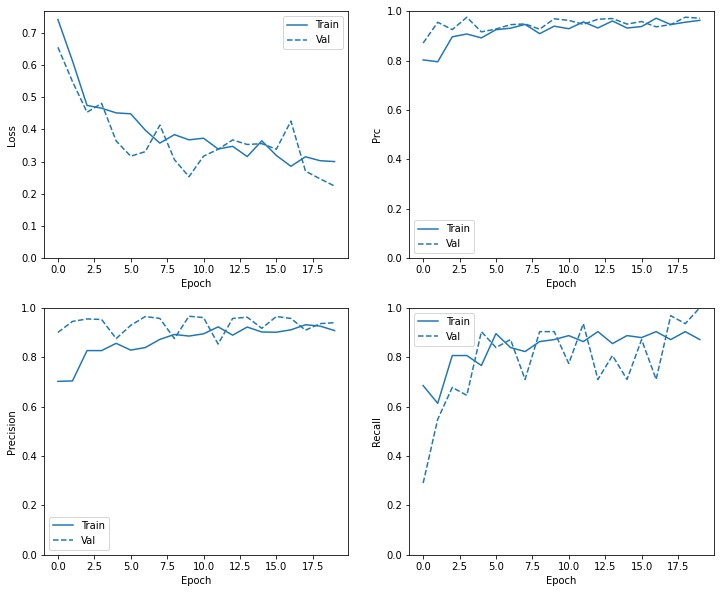

In [314]:
plot_metrics(history)

<p style="font-family: Georgia;font-size: 120%"> It seems that MobileNetV2 was a bit better than this one, but I am pretty sure it is matter of how we fine-tune our models. Let's now observe last model. </p>

<a id = "models-transfer_learning-vgg16"></a>

### VGG16

<a id = "models-transfer_learning-vgg16-structure"></a>
#### Model Structure

![VGG16 Architecture](https://www.researchgate.net/profile/Max-Ferguson/publication/322512435/figure/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png)

<a id = "models-transfer_learning-vgg16-training"></a>
#### Training

In [315]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              tf.keras.layers.GlobalMaxPooling2D(),
                              tf.keras.layers.Dense(4096, activation = 'relu'),
                              tf.keras.layers.Dropout(rate=0.5),
                              tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.0001),
                loss = "binary_crossentropy",
                metrics=metrics)

In [316]:
history4 = model.fit(train_generator,epochs = 20, validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/20
21/21 [==============================] - 7s 265ms/step - loss: 0.7255 - tp: 104.0000 - fp: 42.0000 - tn: 56.0000 - fn: 51.0000 - accuracy: 0.6324 - precision: 0.7123 - recall: 0.6710 - auc: 0.6964 - prc: 0.7858 - val_loss: 0.5041 - val_tp: 31.0000 - val_fp: 10.0000 - val_tn: 9.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8000 - val_precision: 0.7561 - val_recall: 1.0000 - val_auc: 0.9151 - val_prc: 0.9401
Epoch 2/20
21/21 [==============================] - 4s 213ms/step - loss: 0.5525 - tp: 86.0000 - fp: 22.0000 - tn: 57.0000 - fn: 38.0000 - accuracy: 0.7044 - precision: 0.7963 - recall: 0.6935 - auc: 0.7999 - prc: 0.8569 - val_loss: 0.4585 - val_tp: 31.0000 - val_fp: 14.0000 - val_tn: 5.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.7200 - val_precision: 0.6889 - val_recall: 1.0000 - val_auc: 0.9389 - val_prc: 0.9533
Epoch 3/20
21/21 [==============================] - 4s 186ms/step - loss: 0.4957 - tp: 104.0000 - fp: 19.0000 - tn: 60.0000 - fn: 20.0000 - accuracy: 0.8079 - prec

In [317]:
validation_results = model.evaluate(validation_generator, verbose=0)

for name, value in zip(model.metrics_names, validation_results):
  print(name, ': ', value)

loss :  0.329720139503479
tp :  24.0
fp :  1.0
tn :  18.0
fn :  7.0
accuracy :  0.8399999737739563
precision :  0.9599999785423279
recall :  0.774193525314331
auc :  0.9550085067749023
prc :  0.9627295732498169


Non-tumor detected (True Negatives):  17
Non-tumor incorrectly detected (False Positives):  2
Tumor missed (False Negatives):  6
Tumor detected (True Positives):  25
Total case:  31


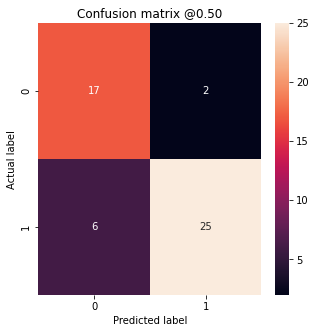

In [318]:
validation_predictions = model.predict(validation_generator)

labels = validation_generator.classes

plot_cm(labels, validation_predictions)

<a id = "models-transfer_learning-vgg16-results"></a>

#### Results

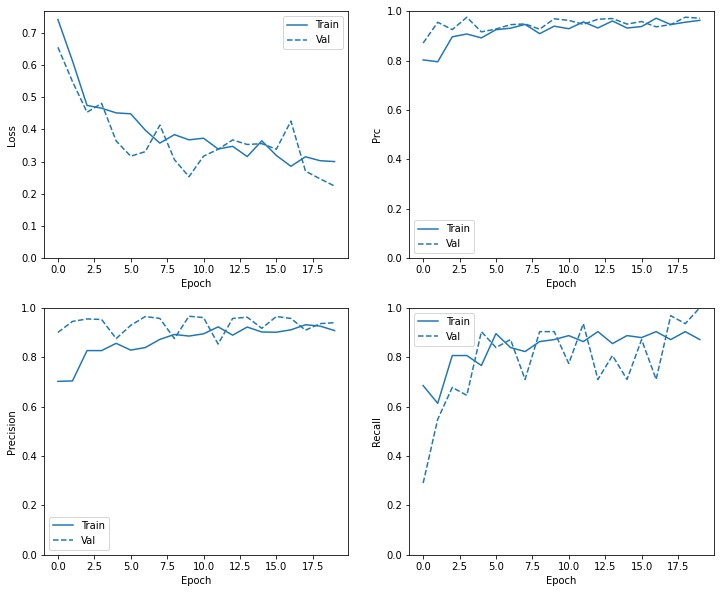

In [319]:
plot_metrics(history)

<p style="font-family: Georgia;font-size: 120%"> Results are pretty fine, but still in comparison to MobileNetV2 metrics are flactuating for this model. </p>

<a id="conclusion"></a>

# Conclusion

<p style="font-family: Georgia;font-size: 120%"> In conclusion, brain tumor is one of the major health problems related with human brains. They usually occur due to fast growth of abnormal or damaged cells and created lamps of tissue in the brain. Thus, ability of machines to determine brain tumor from given image is appreciated in medicine. In this notebook we applied several models such as simple CNN, MobileNetV2, InseptionResNetV2, and VGG16 across various measurment metrics. Clear that in this case it is difficult to draw exact perfomance accuracy for each of the models since <i>k-fold cross validation</i> should be applied for that. Additionally, since at each validation step ImageDataGenerator randomly applies transformation, it might affect results obtained from validation, as well. Below one can find table of metrics for each model at one run-time. Any further improvments are up to reader so please don't hesitate to fork this notebook :) </p>

<a id="conclusion-overall_results"></a>

## Overall Results

In [328]:
res = [["Simple CNN", ],
       ["MobileNetV2", ],
       ["InceptionResNetV2", ],
       ["VGG16", ]]
histories = [history1,history2,history3,history4]

for i,hist in enumerate(histories):
    
    hist_li = list(hist.history.values())
    
    acc = hist_li[15][0]
    precision = hist_li[16][0]
    recall = hist_li[17][0]
    max_auc = hist_li[18][0]
    
    mean_acc = np.mean(hist_li[15])
    mean_precision = np.mean(hist_li[16])
    mean_recall = np.mean(hist_li[17])
    mean_auc = np.mean(hist_li[18])
    
    
    for j in range(len(hist_li[16])):
        if hist_li[18][j] > max_auc: # finding epoch with maximum AUC achieved
            
            acc = hist_li[15][j]
            precision = hist_li[16][j]
            recall = hist_li[17][j]
            max_auc = hist_li[18][j]
        
    
    res[i] += [precision,recall, max_auc, acc,mean_precision, mean_recall,mean_auc,mean_acc]
    
df = pd.DataFrame(res, columns = ["Model Name", f"Precision (with Max AUC)","Recall (with Max AUC)"," Max AUC", "Accuracy",
                                 "Mean Precision", "Mean Recall","Mean AUC", "Mean Accuracy"])

df

,Model Name,Precision (with Max AUC),Recall (with Max AUC),Max AUC,Accuracy,Mean Precision,Mean Recall,Mean AUC,Mean Accuracy
0,Simple CNN,0.818182,0.870968,0.896435,0.80,0.773411,0.854839,0.802037,0.753
1,MobileNetV2,0.966667,0.935484,0.988115,0.94,0.956002,0.908065,0.969567,0.916
2,InceptionResNetV2,0.964286,0.870968,0.964346,0.90,0.893168,0.877419,0.931919,0.854
3,VGG16,0.961538,0.806452,0.974533,0.86,0.896765,0.879032,0.937818,0.854


<p style="font-family: Georgia;font-size: 120%"> Please don't be confused with <i> Accuracy </i> metrics since it is not the best one to measure perfomance for <font color="red">imbalanced</font> data in binary classification problem. </p>